<a href="https://colab.research.google.com/github/carson-evans/cat-dog-classifier/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [9]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

--2024-03-21 16:52:27--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   105MB/s    in 0.6s    

2024-03-21 16:52:28 (105 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [10]:
# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
                                            directory=train_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=42
                                        )
val_data_gen = validation_image_generator.flow_from_directory(
                                            directory=validation_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=42
                                        )
test_data_gen = test_image_generator.flow_from_directory(
                                            directory=PATH,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            classes=['test'],
                                            shuffle=False,
                                            seed=42
                                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


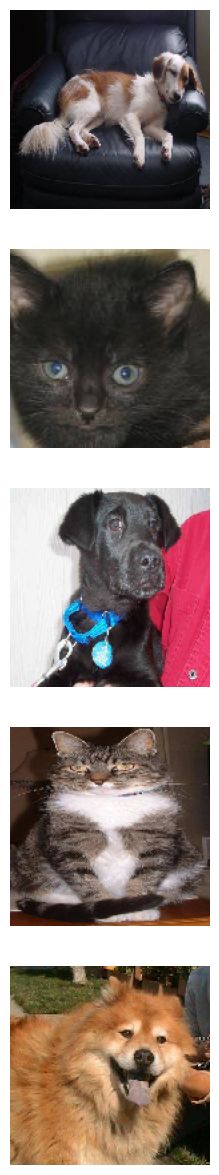

In [11]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [12]:
# 5
train_image_generator = ImageDataGenerator(rotation_range=15,
                                           shear_range=0.1,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           rescale=1./255
                                           )


Found 2000 images belonging to 2 classes.


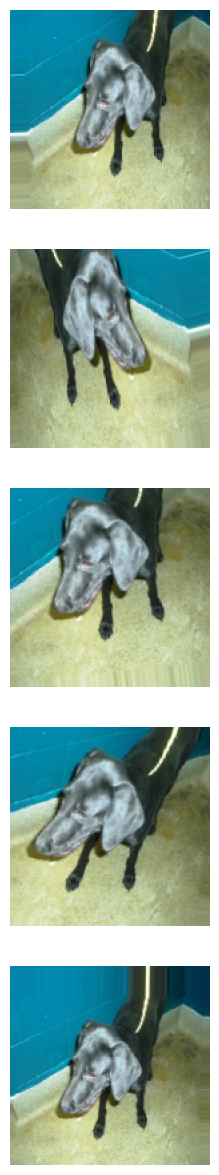

In [13]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [14]:
# network parameters
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.5
num_labels = 2

model = Sequential()
model.add(Conv2D(filters=16,
                  kernel_size=kernel_size,
                  activation='relu',
                  input_shape=input_shape)
                  )
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=32,
                  kernel_size=kernel_size,
                  activation='relu')
                  )
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=64,
                  kernel_size=kernel_size,
                  activation='relu')
                  )
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=128,
                  kernel_size=kernel_size,
                  activation='relu')
                  )
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add( Dense(1, activation='sigmoid') )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 64)       

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
step_size_train=train_data_gen.n//train_data_gen.batch_size
step_size_valid=val_data_gen.n//val_data_gen.batch_size

# Stopping condition
callback = EarlyStopping(monitor='val_loss',
                                  mode="min",
                                  patience=3,
                                  restore_best_weights=True)

history = model.fit(train_data_gen,
                    epochs=epochs,
                    steps_per_epoch=step_size_train,
                    batch_size=batch_size,
                    validation_data=val_data_gen,
                    validation_steps=step_size_valid,
                    callbacks=[callback]
                    )

Epoch 1/15
15/15 [==============================] - 67s 4s/step - loss: 0.7033 - accuracy: 0.5091 - val_loss: 0.6916 - val_accuracy: 0.5391
Epoch 2/15
15/15 [==============================] - 62s 4s/step - loss: 0.6908 - accuracy: 0.5176 - val_loss: 0.6815 - val_accuracy: 0.5625
Epoch 3/15
15/15 [==============================] - 61s 4s/step - loss: 0.6928 - accuracy: 0.5294 - val_loss: 0.6886 - val_accuracy: 0.5022
Epoch 4/15
15/15 [==============================] - 62s 4s/step - loss: 0.6864 - accuracy: 0.5636 - val_loss: 0.6743 - val_accuracy: 0.5536
Epoch 5/15
15/15 [==============================] - 62s 4s/step - loss: 0.6625 - accuracy: 0.5972 - val_loss: 0.6250 - val_accuracy: 0.6384
Epoch 6/15
15/15 [==============================] - 61s 4s/step - loss: 0.6416 - accuracy: 0.6400 - val_loss: 0.6335 - val_accuracy: 0.6451
Epoch 7/15
15/15 [==============================] - 62s 4s/step - loss: 0.6207 - accuracy: 0.6656 - val_loss: 0.5809 - val_accuracy: 0.6797
Epoch 8/15
15/15 [==

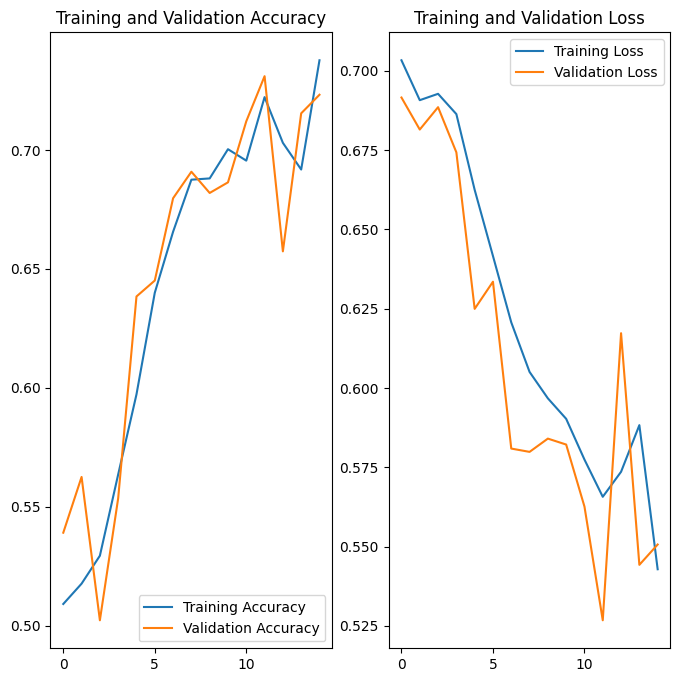

In [21]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 772ms/step


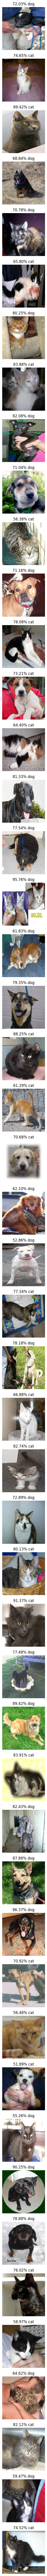

In [22]:
probabilities = model.predict(test_data_gen)
probabilities = probabilities.reshape(-1)
probabilities = probabilities.tolist()

sample_testing_images, _ = next(test_data_gen)
plotImages(sample_testing_images, probabilities = probabilities)

In [23]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 76.0% of the images of cats and dogs.
You passed the challenge!
